In [1]:
from pandeia.engine.perform_calculation import perform_calculation
from pandeia.engine.calc_utils import build_default_calc
import numpy as np
import stpsf
from stpsf import roman
from scipy.interpolate import RegularGridInterpolator
from tqdm import tqdm
import os
import pandas as pd

import matplotlib
from matplotlib import gridspec
import matplotlib.pyplot as plt

font = {'family' : 'serif',
        'size'   : 16,}
matplotlib.rc('font', **font)

import os

plotpath = './figures/'
if not os.path.isdir(plotpath):
    os.makedirs(plotpath)

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-068 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-072
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


In [2]:
'''
Code adapted from original code by Eddie Schlafly 
'''

filts = ['f062','f087','f106','f129','f158','f184','f213']
wfi = roman.WFI()

# Lancaster+2022
ab_minus_vega = dict(f062=0.147,
                     f087=0.485,
                     f106=0.647,
                     f129=0.950,
                     f146=1.012,
                     f158=1.281,
                     f184=1.546,
                     f213=1.819)

#see here for WFI MultiAccum Table descriptions:
#https://roman-docs.stsci.edu/roman-instruments-home/wfi-imaging-mode-user-guide/observing-with-the-wfi-in-imaging-mode/wfi-multiaccum-tables

allowed_ma_names = ['IM_60_6_S','IM_66_6','IM_76_7_S','IM_85_7','IM_95_7','IM_101_7','IM_107_7','IM_107_8_S','IM_120_8',\
                    'IM_135_8','IM_152_9','IM_171_10','IM_193_11','IM_193_14_S','IM_225_13','IM_250_14','IM_284_14',\
                    'IM_294_16','IM_307_16','IM_360_16','IM_409_16','IM_420_16','IM_460_16','IM_500_16','IM_550_16',\
                    'IM_600_16','IM_650_16','IM_700_16','IM_750_16','IM_800_16','IM_900_16','IM_950_16','IM_1000_16']

allowed_backgrounds = ['hltds','gbtds_mid_5stripe',\
                       'hlwas-medium_field1','hlwas-medium_field2',\
                       'hlwas-wide_field1','hlwas-wide_field2',\
                       'hlwas-wide_field3','hlwas-wide_field4']

# allowed_background_levels = ['high','medium','low']
allowed_background_levels = ['medium']

ma_integration_times = {}
for name in allowed_ma_names:
    ma_integration_times[name] = int(name.split('_')[1])

def get_psf_report(filt,mag,ma_table_name,
                   background,background_level):
    """
    SNR from Pandeia.  Lots of stuff in the "report."
    Supposed to give the SNR in a 0.2" aperture for a point source
    given a particular background level.
    """
    calc = build_default_calc('roman', 'wfi', 'imaging')
    # default source is a point source
    calc['scene'][0]['spectrum']['normalization']['norm_flux'] = mag
    calc['scene'][0]['spectrum']['normalization']['norm_fluxunit'] = 'abmag'
    calc['configuration']['detector']['nexp'] = 1
    calc['configuration']['instrument']['filter'] = filt
    calc['configuration']['detector']['ma_table_name'] = ma_table_name
    calc['strategy']['background_subtraction'] = True
    calc['strategy']['aperture_size'] = 0.2 #default
    calc['strategy']['sky_annulus'] = [0.4, 0.6] #default
    calc['background'] = background
    calc['background_level'] = background_level
    report = perform_calculation(calc)
    return report


def snr_vs_mag(filt, mag, ma_table_name, 
               background = 'hlwas-wide_field1',
               background_level = 'medium'):
    return np.array([get_psf_report(filt, 
                                    mag0, 
                                    ma_table_name, 
                                    background, 
                                    background_level)['scalar']['sn'] for mag0 in mag])


In [3]:

def pos_err_plots(ma_table_name,
          filts=filts,
          errfloor = 0.01,
          vega=False,
          factors = None,
          mag = np.linspace(16, 29, 21, endpoint=True), 
          background = 'hlwas-wide_field1',
          background_level = 'medium',
          show_plots = True):
    if type(factors) == type(None):
        factors = np.ones(len(filts))
        
    if show_plots:
        plt.figure(figsize=(8,10))
        plt.clf()

    outdata = {}
    for filt_ind,filt in enumerate(filts):
        wfi.filter = filt.upper()

        magplot = mag.copy()
        if vega:
            magplot -= ab_minus_vega[filt]
        snr = snr_vs_mag(filt, mag, ma_table_name, 
                        background=background, 
                        background_level=background_level)
        
        asterr = (wfi.pixelscale*1000) / snr * factors[filt_ind]
        outdata[filt] = {
            'mags':mag,
            'magplot':magplot,
            'vega':vega,
            'pos_errs':asterr,
            'snrs':snr,
        }
        
        if show_plots:
            plt.subplot(3, 1, 1)
            plt.plot(magplot, snr, label=filt.upper())
            plt.subplot(3, 1, 2)
            plt.plot(magplot, asterr, label=filt.upper())
                
    if show_plots:
        ax = plt.subplot(3, 1, 1)
        plt.ylim(0.1, 1000)
        plt.yscale('log')
        plt.ylabel('S/N')
        leg = plt.legend(loc='best')
        for line in leg.get_lines():
            line.set_linewidth(5.0)
        plt.grid()
        plt.gca().xaxis.set_ticklabels([])

        ax = plt.subplot(3, 1, 2)
        if not vega:
            plt.xlabel('AB mag')
        else:
            plt.xlabel('Vega mag')
        plt.ylim(0.1, 1000)
        plt.axhline(errfloor*(wfi.pixelscale*1000),c='r',ls='--',lw=1)
        plt.ylabel('Position Uncertainty (mas)')
        plt.yscale('log')
        plt.grid()
    
        plt.subplots_adjust(hspace=0.1)
        plt.show()
        plt.close('all')

    return outdata


In [4]:
'''
Read in a corresponding filter's PSF to measure the position uncertainty.
Specifically, learn the relationship between the flux uncertainty (i.e. S/N)
and the uncertainty in X,Y position. I find that this is a single number that
does not change as a function of flux, so we only need to learn one number
per filter that captures the position uncertainty as a function of S/N or mag.
'''

np.random.seed(101)


n_repeat = 1 #can repeat the data draws to explore statistics, but average final results are the same as 1 draw
n_subpixel = 5 #number of subpixels for super sampling the PSF
dmu = 0.0001 #for numerical dervatives of x and y positions
n_mask = 5 #number of pixels to mask at edges of data (i.e. only look at core)
true_dx,true_dy = 0.,0. #keep set to 0 for these tests
fluxes = np.logspace(-1,6,8)[::-1] #fluxes to test (above background)

all_filt_data = {}
cutout_size = 101

for filt in wfi.filter_list:
    filt = str(filt)
    if not filt.startswith('F'):
        continue
    print(filt)
    
    wfi = roman.WFI()
    wfi.filter = filt
    pixscale = wfi.pixelscale
    
    wfipsf = wfi.calc_psf(fov_pixels=cutout_size+2*n_mask,oversample=n_subpixel)

    x_mean = np.nanmean(wfipsf[0].data,axis=0)
    y_mean = np.nanmean(wfipsf[0].data,axis=1)
    
    start,stop = np.where(x_mean > x_mean.max()*0.5)[0][[0,-1]]
    start_slope = np.diff(x_mean[[start-1,start]])
    start_inter = x_mean[start]-start_slope*start
    stop_slope = np.diff(x_mean[[stop,stop+1]])
    stop_inter = x_mean[stop]-stop_slope*stop
    
    start_x = (x_mean.max()*0.5-start_inter)/start_slope
    stop_x = (x_mean.max()*0.5-stop_inter)/stop_slope
    
    start,stop = np.where(y_mean > y_mean.max()*0.5)[0][[0,-1]]
    start_slope = np.diff(y_mean[[start-1,start]])
    start_inter = y_mean[start]-start_slope*start
    stop_slope = np.diff(y_mean[[stop,stop+1]])
    stop_inter = y_mean[stop]-stop_slope*stop
    
    start_y = (y_mean.max()*0.5-start_inter)/start_slope
    stop_y = (y_mean.max()*0.5-stop_inter)/stop_slope
    
    fwhm_x = ((stop_x-start_x)/n_subpixel)[0]
    fwhm_y = ((stop_y-start_y)/n_subpixel)[0]
    
    # print(fwhm_x,fwhm_y,0.5*(fwhm_x+fwhm_y),(fwhm_x*fwhm_y)**0.5)

    
    wfipsf[1].data[:n_mask] = np.nan
    wfipsf[1].data[-n_mask:] = np.nan
    wfipsf[1].data[:,:n_mask] = np.nan
    wfipsf[1].data[:,-n_mask:] = np.nan

    subpix_edges = np.linspace(-0.5,0.5,n_subpixel+1)
    subpix_centers = 0.5*(subpix_edges[1:]+subpix_edges[:-1])
    x_coords = (np.arange(wfipsf[1].data.shape[0])-wfipsf[1].data.shape[0]//2)
    
    sub_x = np.sort(np.ravel(x_coords[:,None]+subpix_centers))
    
    sub_xx,sub_yy = np.meshgrid(sub_x,sub_x)
    sub_xy = np.zeros((*sub_xx.shape,2))
    sub_xy[:,:,0] = sub_xx
    sub_xy[:,:,1] = sub_yy
    
    model = wfipsf[0].data
    interpolator = RegularGridInterpolator((sub_x,sub_x),model,bounds_error=False,fill_value=None)
    
    all_snrs = np.zeros((n_repeat,len(fluxes)))
    all_param_errs = np.zeros((n_repeat,len(fluxes),3))
    all_sigmas = np.zeros((n_repeat,len(fluxes)))
    all_true_params = np.zeros((n_repeat,len(fluxes),3))
    
    for r_ind,_ in enumerate(tqdm(np.arange(n_repeat),total=n_repeat)):
        
        flux_snrs = np.zeros_like(fluxes)
        flux_param_errs = np.zeros((len(fluxes),3))
        flux_sigmas = np.zeros((len(fluxes)))
        
        dx,dy = true_dx,true_dy
        
        for flux_ind,flux in enumerate(fluxes):    
            truth = np.array([true_dx,true_dy,flux])
        
            data_1d = np.ravel(wfipsf[1].data)*flux
            errs_1d = np.sqrt(data_1d)
            # data_1d = np.random.poisson(data_1d)
            data_1d += np.random.randn(len(data_1d))*errs_1d
            bad_data = ~np.isfinite(data_1d)
            data_1d[bad_data] = 0
            ivars_1d = np.power(errs_1d,-2)
            ivars_1d[bad_data] = 0
            
            new_model = interpolator(sub_xy-np.array([dx,dy]))
            new_model_px = interpolator(sub_xy-np.array([dx+dmu,dy]))
            new_model_mx = interpolator(sub_xy-np.array([dx-dmu,dy]))
            new_model_py = interpolator(sub_xy-np.array([dx,dy+dmu]))
            new_model_my = interpolator(sub_xy-np.array([dx,dy-dmu]))
            
            temp_model = np.copy(new_model[::n_subpixel])
            temp_model_px = np.copy(new_model_px[::n_subpixel])
            temp_model_mx = np.copy(new_model_mx[::n_subpixel])
            temp_model_py = np.copy(new_model_py[::n_subpixel])
            temp_model_my = np.copy(new_model_my[::n_subpixel])
            for j in range(1,n_subpixel):
                temp_model += new_model[j::n_subpixel]
                temp_model_px += new_model_px[j::n_subpixel]
                temp_model_mx += new_model_mx[j::n_subpixel]
                temp_model_py += new_model_py[j::n_subpixel]
                temp_model_my += new_model_my[j::n_subpixel]
            out_model = np.copy(temp_model[:,::n_subpixel])
            out_model_px = np.copy(temp_model_px[:,::n_subpixel])
            out_model_mx = np.copy(temp_model_mx[:,::n_subpixel])
            out_model_py = np.copy(temp_model_py[:,::n_subpixel])
            out_model_my = np.copy(temp_model_my[:,::n_subpixel])
            for j in range(1,n_subpixel):
                out_model += temp_model[:,j::n_subpixel]
                out_model_px += temp_model_px[:,j::n_subpixel]
                out_model_mx += temp_model_mx[:,j::n_subpixel]
                out_model_py += temp_model_py[:,j::n_subpixel]
                out_model_my += temp_model_my[:,j::n_subpixel]
            
            dm_dx = (out_model_px-out_model_mx)/(2*dmu)
            dm_dy = (out_model_py-out_model_my)/(2*dmu)
            
            
            deriv_mat = np.zeros((dm_dx.size,3))
            deriv_mat[:,0] = np.ravel(dm_dx.T*flux)
            deriv_mat[:,1] = np.ravel(dm_dy.T*flux)
            deriv_mat[:,2] = np.ravel(out_model.T)
            
            V_inv_dot_design = deriv_mat*ivars_1d[:,None]
            V_inv = np.einsum('ji,jk->ik',deriv_mat,V_inv_dot_design)
            V = np.linalg.inv(V_inv)
            change_vect = np.linalg.solve(V_inv,np.einsum('ji,j->i',V_inv_dot_design,(data_1d-np.ravel(out_model.T*flux))))
            
            curr_params = np.array([dx,dy,flux])
            new_params = curr_params+change_vect

        
            flux_snrs[flux_ind] = flux/np.sqrt((V[2,2]))
            flux_param_errs[flux_ind] = np.sqrt(np.diag(V))
            flux_sigmas[flux_ind] = np.sqrt(np.dot(np.dot(new_params-truth,V_inv),new_params-truth))
    
            all_true_params[r_ind,flux_ind] = truth

            # print(V)
            # print(flux_param_errs[flux_ind])
            # print(V/flux_param_errs[flux_ind,None,:]/flux_param_errs[flux_ind,:,None])
    
        all_snrs[r_ind] = flux_snrs
        all_param_errs[r_ind] = flux_param_errs
        all_sigmas[r_ind] = flux_sigmas
            
    all_filt_data[filt] = {
        'snrs':all_snrs,
        'fluxes':fluxes,
        'param_errs':all_param_errs,
        'sigmas':all_sigmas,
        'true_params':all_true_params,
        'snr_to_pos_err_mult':np.median((np.mean(all_param_errs[:,:,:2],axis=-1)*all_snrs)),
        'fwhm_x':fwhm_x,
        'fwhm_y':fwhm_y,
    }



F062


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


F087


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.48it/s]


F106


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]


F129


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.50it/s]


F146


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.49it/s]


F158


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.42it/s]


F184


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.38it/s]


F213


Attempted to get aberrations at wavelength 2.3e-06 outside the range of the reference data; clipping to closest wavelength 2.3e-06
Attempted to get aberrations at wavelength 2.3e-06 outside the range of the reference data; clipping to closest wavelength 2.3e-06
Attempted to get aberrations at wavelength 2.3e-06 outside the range of the reference data; clipping to closest wavelength 2.3e-06
Attempted to get aberrations at wavelength 2.3e-06 outside the range of the reference data; clipping to closest wavelength 2.3e-06
Attempted to get aberrations at wavelength 2.3e-06 outside the range of the reference data; clipping to closest wavelength 2.3e-06
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.44it/s]


In [13]:
'''
There is a single factor that allows you to go from S/N of the flux
to the uncertainty in position, that is pos_uncert = 1/(S/N)*factor
'''

good_filt_list = []
good_filt_snr_to_pos_err_factors = []
print(r'Filter & $k$ & FWHM$_x$ & FWHM$_y$ & FWHM$_\mathrm{ave}$ & $\kappa_\mathrm{ave}$')
for filt in wfi.filter_list:
    filt = str(filt)
    if not filt.startswith('F'):
        continue
    fwhm_ave = 0.5*(all_filt_data[filt]['fwhm_x'] + all_filt_data[filt]['fwhm_y'])
    # print(filt,round(all_filt_data[filt]['snr_to_pos_err_mult'],3))
    print('%s & %.03f & %.03f & %.03f & %.03f & %.03f \\\\'%(filt,
                                  all_filt_data[filt]['snr_to_pos_err_mult'],
                                  all_filt_data[filt]['fwhm_x'],
                                  all_filt_data[filt]['fwhm_y'],
                                  fwhm_ave,
                                  all_filt_data[filt]['snr_to_pos_err_mult']/fwhm_ave))
    
    good_filt_list.append(filt.lower())
    good_filt_snr_to_pos_err_factors.append(all_filt_data[filt]['snr_to_pos_err_mult'])


Filter & $k$ & FWHM$_x$ & FWHM$_y$ & FWHM$_\mathrm{ave}$ & $\kappa_\mathrm{ave}$
F062 & 0.858 & 0.585 & 0.605 & 0.595 & 1.441 \\
F087 & 0.763 & 0.728 & 0.757 & 0.742 & 1.028 \\
F106 & 0.709 & 0.874 & 0.905 & 0.889 & 0.797 \\
F129 & 0.713 & 1.031 & 1.068 & 1.050 & 0.680 \\
F146 & 0.792 & 1.024 & 1.063 & 1.044 & 0.758 \\
F158 & 0.756 & 1.249 & 1.295 & 1.272 & 0.594 \\
F184 & 0.784 & 1.444 & 1.508 & 1.476 & 0.531 \\
F213 & 0.873 & 1.664 & 1.741 & 1.702 & 0.513 \\


/opt/anaconda3/envs/roman_new/lib/python3.12/site-packages/pandeia/engine/detector.py:915: RuntimeWarning: invalid value encountered in divide
  k_i = (f_0 * tmean - f_1) * w_ij / d
/opt/anaconda3/envs/roman_new/lib/python3.12/site-packages/pandeia/engine/report.py:781: RuntimeWarning: divide by zero encountered in scalar divide
  self.r['scalar']['sn'] = signal/noise
/var/folders/xs/flwfyss51t7d8vd8jhqz00xh0000gn/T/ipykernel_19027/4114471953.py:28: RuntimeWarning: divide by zero encountered in divide
  asterr = (wfi.pixelscale*1000) / snr * factors[filt_ind]


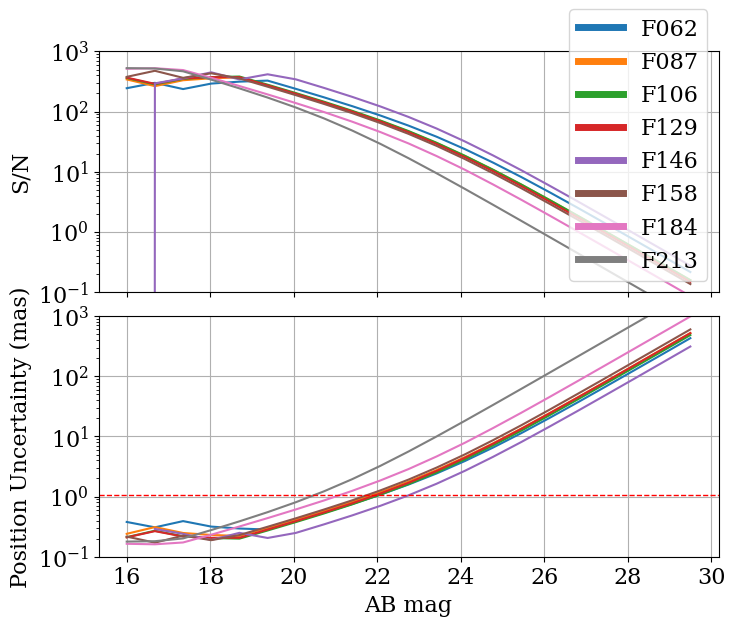

In [6]:
ma_table_name = 'IM_193_11'
# ma_table_name = 'IM_107_7'
plotdata = pos_err_plots(ma_table_name = ma_table_name,
                         filts = good_filt_list,
                         errfloor = 0.01,
                         vega = False,
                         factors = good_filt_snr_to_pos_err_factors,
                         mag = np.linspace(16, 29.5, 21, endpoint=True), 
                         background = 'hlwas-wide_field1',
                         background_level = 'medium',
                         show_plots = True)


In [37]:
'''
Compare multiplication factor with 2D Gaussian
'''

sigma = 2.5
mu = np.array([0,0])
x = np.arange(-5*sigma,5*sigma+1)
y = x
xx,yy = np.meshgrid(x,y)
xy = np.zeros((xx.size,2))
xy[:,0] = np.ravel(xx)
xy[:,1] = np.ravel(yy)

flux = 10000
def model(xy,mu,flux):
    diff = xy-mu
    return flux*np.exp(-0.5*np.sum(np.power(diff/sigma,2),axis=1))*(2*np.pi)**(-1)*(sigma**4)**-0.5

z_true = model(xy,mu,flux)
z_errs = np.sqrt(z_true)
z_ivars = np.power(z_errs,-2)
z_data = z_true + np.random.randn(*z_true.shape)*z_errs

dmu = 0.0001
dm_dx = (model(xy,mu+np.array([dmu,0]),flux)-model(xy,mu+np.array([-dmu,0]),flux))/(2*dmu)
dm_dy = (model(xy,mu+np.array([0,dmu]),flux)-model(xy,mu+np.array([0,-dmu]),flux))/(2*dmu)
dm_dflux = model(xy,mu,flux)/flux

deriv_mat = np.zeros((dm_dx.size,3))
deriv_mat[:,0] = dm_dx
deriv_mat[:,1] = dm_dy
deriv_mat[:,2] = dm_dflux

V_inv_dot_design = deriv_mat*z_ivars[:,None]
V_inv = np.einsum('ji,jk->ik',deriv_mat,V_inv_dot_design)
V = np.linalg.inv(V_inv)
change_vect = np.linalg.solve(V_inv,np.einsum('ji,j->i',V_inv_dot_design,(z_data-z_true)))

flux_snr = flux/np.sqrt((V[2,2]))
flux_param_errs = np.sqrt(np.diag(V))


print('Position errors (pixels):',flux_param_errs[:-1])
print('k/Gaussian_sigma:',flux_param_errs[:-1]*flux_snr/sigma)

Position errors (pixels): [0.02500006 0.02500006]
k/Gaussian_sigma: [1.00000238 1.00000238]


In [21]:
'''
Read in a corresponding filter's PSF to measure the position uncertainty.
Specifically, learn the relationship between the flux uncertainty (i.e. S/N)
and the uncertainty in X,Y position. I find that this is a single number that
does not change as a function of flux, so we only need to learn one number
per filter that captures the position uncertainty as a function of S/N or mag.
'''

np.random.seed(101)

all_filt_snr_mults = {}

#test effect of changing PSF cutout using differenx NxN sizes
n_cutout_pixels = [3,5,7,9,11,13,15,17,19,21,25,31,41,51,75,101,151,201,301] 

for filt in wfi.filter_list:
    filt = str(filt)
    if not filt.startswith('F'):
        continue
    print(filt)
    all_filt_snr_mults[filt] = np.zeros(len(n_cutout_pixels))
    for cutout_ind,cutout_size in enumerate(tqdm(n_cutout_pixels,total=len(n_cutout_pixels))):
        
        wfi = roman.WFI()
        wfi.filter = filt
        pixscale = wfi.pixelscale
        
        wfipsf = wfi.calc_psf(fov_pixels=cutout_size+2*n_mask,oversample=n_subpixel)
        wfipsf[1].data[:n_mask] = np.nan
        wfipsf[1].data[-n_mask:] = np.nan
        wfipsf[1].data[:,:n_mask] = np.nan
        wfipsf[1].data[:,-n_mask:] = np.nan
    
        subpix_edges = np.linspace(-0.5,0.5,n_subpixel+1)
        subpix_centers = 0.5*(subpix_edges[1:]+subpix_edges[:-1])
        x_coords = (np.arange(wfipsf[1].data.shape[0])-wfipsf[1].data.shape[0]//2)
        
        sub_x = np.sort(np.ravel(x_coords[:,None]+subpix_centers))
        
        sub_xx,sub_yy = np.meshgrid(sub_x,sub_x)
        sub_xy = np.zeros((*sub_xx.shape,2))
        sub_xy[:,:,0] = sub_xx
        sub_xy[:,:,1] = sub_yy
        
        model = wfipsf[0].data
        interpolator = RegularGridInterpolator((sub_x,sub_x),model,bounds_error=False,fill_value=None)
        
        all_snrs = np.zeros((n_repeat,len(fluxes)))
        all_param_errs = np.zeros((n_repeat,len(fluxes),3))
        all_sigmas = np.zeros((n_repeat,len(fluxes)))
        all_true_params = np.zeros((n_repeat,len(fluxes),3))
        
        for r_ind,_ in enumerate(tqdm(np.arange(n_repeat),total=n_repeat,disable=True)):
            
            flux_snrs = np.zeros_like(fluxes)
            flux_param_errs = np.zeros((len(fluxes),3))
            flux_sigmas = np.zeros((len(fluxes)))
            
            dx,dy = true_dx,true_dy
            
            for flux_ind,flux in enumerate(fluxes):    
                truth = np.array([true_dx,true_dy,flux])
            
                data_1d = np.ravel(wfipsf[1].data)*flux
                errs_1d = np.sqrt(data_1d)
                # data_1d = np.random.poisson(data_1d)
                data_1d += np.random.randn(len(data_1d))*errs_1d
                bad_data = ~np.isfinite(data_1d)
                data_1d[bad_data] = 0
                ivars_1d = np.power(errs_1d,-2)
                ivars_1d[bad_data] = 0
                
                new_model = interpolator(sub_xy-np.array([dx,dy]))
                new_model_px = interpolator(sub_xy-np.array([dx+dmu,dy]))
                new_model_mx = interpolator(sub_xy-np.array([dx-dmu,dy]))
                new_model_py = interpolator(sub_xy-np.array([dx,dy+dmu]))
                new_model_my = interpolator(sub_xy-np.array([dx,dy-dmu]))
                
                temp_model = np.copy(new_model[::n_subpixel])
                temp_model_px = np.copy(new_model_px[::n_subpixel])
                temp_model_mx = np.copy(new_model_mx[::n_subpixel])
                temp_model_py = np.copy(new_model_py[::n_subpixel])
                temp_model_my = np.copy(new_model_my[::n_subpixel])
                for j in range(1,n_subpixel):
                    temp_model += new_model[j::n_subpixel]
                    temp_model_px += new_model_px[j::n_subpixel]
                    temp_model_mx += new_model_mx[j::n_subpixel]
                    temp_model_py += new_model_py[j::n_subpixel]
                    temp_model_my += new_model_my[j::n_subpixel]
                out_model = np.copy(temp_model[:,::n_subpixel])
                out_model_px = np.copy(temp_model_px[:,::n_subpixel])
                out_model_mx = np.copy(temp_model_mx[:,::n_subpixel])
                out_model_py = np.copy(temp_model_py[:,::n_subpixel])
                out_model_my = np.copy(temp_model_my[:,::n_subpixel])
                for j in range(1,n_subpixel):
                    out_model += temp_model[:,j::n_subpixel]
                    out_model_px += temp_model_px[:,j::n_subpixel]
                    out_model_mx += temp_model_mx[:,j::n_subpixel]
                    out_model_py += temp_model_py[:,j::n_subpixel]
                    out_model_my += temp_model_my[:,j::n_subpixel]
                
                dm_dx = (out_model_px-out_model_mx)/(2*dmu)
                dm_dy = (out_model_py-out_model_my)/(2*dmu)
                
                
                deriv_mat = np.zeros((dm_dx.size,3))
                deriv_mat[:,0] = np.ravel(dm_dx.T*flux)
                deriv_mat[:,1] = np.ravel(dm_dy.T*flux)
                deriv_mat[:,2] = np.ravel(out_model.T)
                
                V_inv_dot_design = deriv_mat*ivars_1d[:,None]
                V_inv = np.einsum('ji,jk->ik',deriv_mat,V_inv_dot_design)
                V = np.linalg.inv(V_inv)
                change_vect = np.linalg.solve(V_inv,np.einsum('ji,j->i',V_inv_dot_design,(data_1d-np.ravel(out_model.T*flux))))
                
                curr_params = np.array([dx,dy,flux])
                new_params = curr_params+change_vect
    
            
                flux_snrs[flux_ind] = flux/np.sqrt((V[2,2]))
                flux_param_errs[flux_ind] = np.sqrt(np.diag(V))
                flux_sigmas[flux_ind] = np.sqrt(np.dot(np.dot(new_params-truth,V_inv),new_params-truth))
        
                all_true_params[r_ind,flux_ind] = truth
    
                # print(V)
                # print(flux_param_errs[flux_ind])
                # print(V/flux_param_errs[flux_ind,None,:]/flux_param_errs[flux_ind,:,None])
        
            all_snrs[r_ind] = flux_snrs
            all_param_errs[r_ind] = flux_param_errs
            all_sigmas[r_ind] = flux_sigmas
                
        all_filt_snr_mults[filt][cutout_ind] = np.median((np.mean(all_param_errs[:,:,:2],axis=-1)*all_snrs))


F062


100%|███████████████████████████████████████████| 19/19 [00:57<00:00,  3.02s/it]


F087


100%|███████████████████████████████████████████| 19/19 [00:56<00:00,  2.98s/it]


F106


100%|███████████████████████████████████████████| 19/19 [00:58<00:00,  3.05s/it]


F129


100%|███████████████████████████████████████████| 19/19 [00:58<00:00,  3.08s/it]


F146


100%|███████████████████████████████████████████| 19/19 [01:55<00:00,  6.09s/it]


F158


100%|███████████████████████████████████████████| 19/19 [01:00<00:00,  3.17s/it]


F184


100%|███████████████████████████████████████████| 19/19 [01:00<00:00,  3.16s/it]


F213


  0%|                                                    | 0/19 [00:00<?, ?it/s]Attempted to get aberrations at wavelength 2.3e-06 outside the range of the reference data; clipping to closest wavelength 2.3e-06
Attempted to get aberrations at wavelength 2.3e-06 outside the range of the reference data; clipping to closest wavelength 2.3e-06
Attempted to get aberrations at wavelength 2.3e-06 outside the range of the reference data; clipping to closest wavelength 2.3e-06
Attempted to get aberrations at wavelength 2.3e-06 outside the range of the reference data; clipping to closest wavelength 2.3e-06
Attempted to get aberrations at wavelength 2.3e-06 outside the range of the reference data; clipping to closest wavelength 2.3e-06
  5%|██▎                                         | 1/19 [00:02<00:41,  2.30s/it]Attempted to get aberrations at wavelength 2.3e-06 outside the range of the reference data; clipping to closest wavelength 2.3e-06
Attempted to get aberrations at wavelength 2.3e-06 out

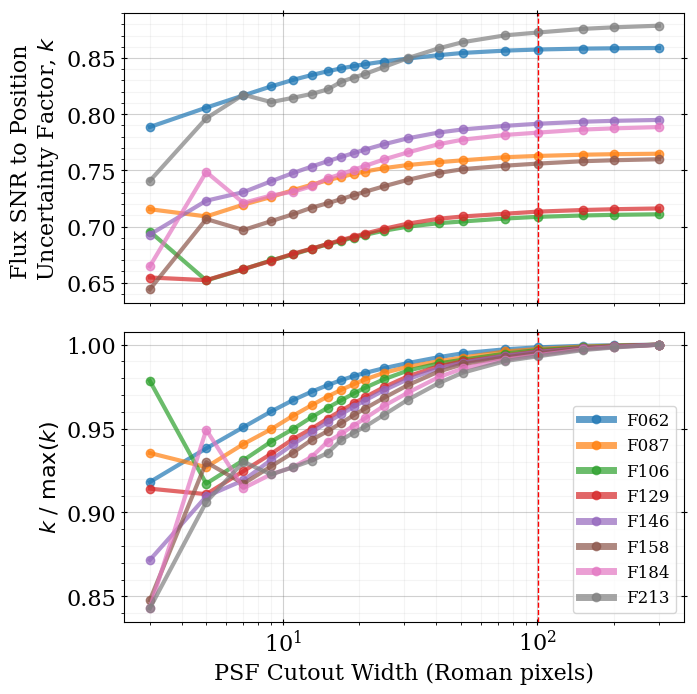

In [67]:
'''
Plot relationship between cutout size and size of the position uncertainty (from a single observations) as a function
of AB magnitude for different Roman filters and different exposure times.
'''

plt.figure(figsize=(7,7))

gs = gridspec.GridSpec(2,1,hspace=0.1, left=0.18, right=0.98, top=0.98, bottom = 0.11)
ax = plt.subplot(gs[0])    
plt.gca().set_xscale('log')
plt.grid(visible=True, which='major', color='#666666', linestyle='-',alpha=0.3)
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.1)
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)
ax.set_xticklabels([])
for filt in all_filt_snr_mults:
    if not filt.startswith('F'):
        continue
    plt.plot(n_cutout_pixels,all_filt_snr_mults[filt],label=filt,lw=3,alpha=0.7,marker='o')
plt.axvline(101,c='r',lw=1,ls='--')
xlim = plt.xlim()
# plt.xlim(xlim[0],xlim[1]*3)
# xlim = plt.xlim()
# leg = plt.legend(loc=1)
# for line in leg.get_lines():
#     line.set_linewidth(5)
plt.ylabel('Flux SNR to Position \nUncertainty Factor, $k$')

ax = plt.subplot(gs[1])    
plt.gca().set_xscale('log')
plt.grid(visible=True, which='major', color='#666666', linestyle='-',alpha=0.3)
plt.minorticks_on()
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.1)
ax.tick_params(axis='both',direction='inout',length=5,bottom=True,left=True,right=True,top=True)
for filt in all_filt_snr_mults:
    if not filt.startswith('F'):
        continue
    plt.plot(n_cutout_pixels,all_filt_snr_mults[filt]/all_filt_snr_mults[filt].max(),label=filt,lw=3,alpha=0.7,marker='o')
plt.axvline(101,c='r',lw=1,ls='--')
plt.xlim(xlim)
leg = plt.legend(loc=4,fontsize=12)
for line in leg.get_lines():
    line.set_linewidth(5)
plt.ylabel(r'$k$ / $\max(k)$')
plt.xlabel('PSF Cutout Width (Roman pixels)')

plt.savefig(f'{plotpath}roman_flux_snr_to_pos_err_factors_vs_cutout.png')
plt.show()


In [23]:
datapath = './data/'
if not os.path.isdir(datapath):
    os.mkdir(datapath)


In [33]:
all_filt_snr_mults['psf_cutout_pixel_width'] = n_cutout_pixels
out_fname = f'{datapath}roman_flux_snr_to_pos_errs.csv'
pd.DataFrame(all_filt_snr_mults).to_csv(out_fname,index=False)


In [24]:

overwrite = False

for background in allowed_backgrounds:
    for background_level in allowed_background_levels:
        background_string = f'{background}_{background_level}'
        for ma_table_name in allowed_ma_names:    
            print(ma_table_name,background_string)
            
            first = True
            bad_data = False 
            for filt in good_filt_list:
                out_fname = f'{datapath}roman_{ma_table_name}_{background_string}_{filt.upper()}_pos_errs.csv'
                if (os.path.isfile(out_fname)) and (not overwrite):
                    continue

                #then need to do the slow calculation (for the first time)
                if first:
                    first = False
                    try:
                        curr_plotdata = pos_err_plots(ma_table_name,
                                                    filts = good_filt_list,
                                                    errfloor = 0.01,
                                                    vega = False,
                                                    factors = good_filt_snr_to_pos_err_factors,
                                                    mag = np.arange(15, 30+0.2, 0.2),
                                                    background = background,
                                                    background_level = background_level,
                                                    show_plots = False)
                    except:
                        print(f'SKIPPING: {out_fname} because measuring position uncertainty failed.')
                        plt.close('all')
                        break
                new_data = { 
                    'mags_ab':curr_plotdata[filt]['mags'],
                    'pos_errs_mas':curr_plotdata[filt]['pos_errs'],
                }
                pd.DataFrame(new_data).to_csv(out_fname,index=False)
                # print(ma_table_name,background_string,filt.upper(),out_fname)
            # print()
    # print()


IM_60_6_S hltds_medium
IM_66_6 hltds_medium
IM_76_7_S hltds_medium
IM_85_7 hltds_medium
IM_95_7 hltds_medium
IM_101_7 hltds_medium
IM_107_7 hltds_medium
IM_107_8_S hltds_medium
IM_120_8 hltds_medium
IM_135_8 hltds_medium
IM_152_9 hltds_medium
IM_171_10 hltds_medium
IM_193_11 hltds_medium
IM_193_14_S hltds_medium
IM_225_13 hltds_medium
IM_250_14 hltds_medium
IM_284_14 hltds_medium
IM_294_16 hltds_medium
IM_307_16 hltds_medium
IM_360_16 hltds_medium
IM_409_16 hltds_medium
IM_420_16 hltds_medium
IM_460_16 hltds_medium
IM_500_16 hltds_medium
IM_550_16 hltds_medium
IM_600_16 hltds_medium
IM_650_16 hltds_medium
IM_700_16 hltds_medium
IM_750_16 hltds_medium
IM_800_16 hltds_medium
IM_900_16 hltds_medium
IM_950_16 hltds_medium
IM_1000_16 hltds_medium
IM_60_6_S gbtds_mid_5stripe_medium
IM_66_6 gbtds_mid_5stripe_medium
IM_76_7_S gbtds_mid_5stripe_medium
IM_85_7 gbtds_mid_5stripe_medium
IM_95_7 gbtds_mid_5stripe_medium
IM_101_7 gbtds_mid_5stripe_medium
IM_107_7 gbtds_mid_5stripe_medium
IM_107_8_S 